In [66]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML


from lane_detection import *
from image_transformation import *
from utils import *

images = glob.glob("test_images/*")

%matplotlib inline

# Analysis

## Distortion correction &  Thresholding  & Region of Interest

In [ ]:
# Undistort image
pts = calibrate_camera()
img  = cv2.imread(images[0])
dst = undistort_image(img, pts)

plt.figure(figsize=(200,100))
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(dst)

In [ ]:
# explanatory analysis to show all the threshold techniques
masked = lane_masking_all(dst)
show_masks(masked)

In [ ]:
FONT_SIZE = 20
masked_img = lane_masking(dst)

plt.figure(figsize=(30,15))
plt.subplot(2,1,1)
plt.imshow(masked_img,cmap='gray')
plt.title('Thresholded Image',fontsize=FONT_SIZE)
_img = region_of_interest(masked_img)
plt.subplot(2,1,2)
plt.imshow(_img,cmap='gray')
plt.title('Region of Interest',fontsize=FONT_SIZE)

## Perspective Transform

In [ ]:
offset = 25
left,right = fit_lanes(_img)
src = retrieve_src_points(left, right, masked_img.shape[0])
dst = np.float32([src[0], (src[0][0], offset), src[2], (src[2][0], offset)])

In [ ]:
# Show the transformation points

plt.imshow(masked_img,cmap='gray')
plt.scatter(src[0][0], src[0][1],c='r')
plt.scatter(src[1][0], src[1][1],c='r')
plt.scatter(src[2][0], src[2][1],c='r')
plt.scatter(src[3][0], src[3][1],c='r')

plt.scatter(dst[0][0], dst[0][1],c='b')
plt.scatter(dst[1][0], dst[1][1],c='b')
plt.scatter(dst[2][0], dst[2][1],c='b')
plt.scatter(dst[3][0], dst[3][1],c='b')

In [ ]:
class PerspectiveTransformer:
    def __init__(self, src, dst):
        self.src = src
        self.dst = dst
        self.M = cv2.getPerspectiveTransform(src, dst)
        self.M_inv = cv2.getPerspectiveTransform(dst, src)

    def transform(self, img):
        return cv2.warpPerspective(img, self.M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

    def inverse_transform(self, img):
        return cv2.warpPerspective(img, self.M_inv, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

In [ ]:
transformer = PerspectiveTransformer(src, dst)
transformed_image = transformer.transform(_img)
plt.imshow(transformed_image,cmap='gray')

## Lane Curvature 

In [ ]:
# # Fit polynomial to compute the curvature
left_fit, right_fit = fit_poly_lanes(transformed_image)

In [ ]:
# Visualize the fit
ploty = np.linspace(0, transformed_image.shape[0]-1, transformed_image.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
plt.imshow(transformed_image,cmap='gray')
plt.plot(left_fitx, ploty, color='red')
plt.plot(right_fitx, ploty, color='blue')

In [ ]:
left_curverad, right_curverad = measure_curvature(left_fit, right_fit, transformed_image.shape[0])

In [ ]:
def retrieve_src_points(left, right, shape):
    y_cutoff = 7 * shape // 10
    left_cutoff_ix = (left[:,1] > y_cutoff).nonzero()[0].max()
    right_cutoff_ix = (right[:,1] > y_cutoff).nonzero()[0].min()
    p1, p2 = left[left_cutoff_ix,], right[right_cutoff_ix,]

    # Retreieve the trapezoid for perspective transformation
    # We can use the points for all images
    l = {}
    l1, l2 = np.array([int(left[:,0].min()), int(left[:,1].max())]), p1

    r = {}
    r1, r2 = np.array([int(right[:,0].max()), int(right[:,1].max())]), p2

    return np.float32([l1, l2, r1, r2])

# Pipeline 

In [2]:
transformer = setup_transformation_pipeline()

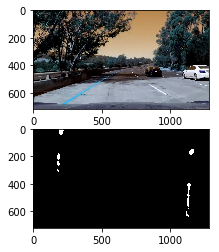

In [58]:
img = cv2.imread(images[-2])
warped = transformer.transform(img)
plt.subplot(2,1,1)
plt.imshow(img,cmap='gray')
plt.subplot(2,1,2)
plt.imshow(warped,cmap='gray')
left_points, right_points = detect_points(warped)

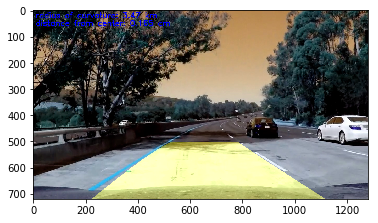

In [60]:
left.process_image(left_points)
right.process_image(right_points)
new_img = overlay_detected_lane(img, transformer, warped, left,right)
plt.imshow(new_img)

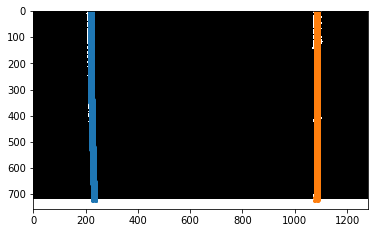

In [8]:
plt.imshow(warped,cmap='gray')
plt.plot(left.x,left.y,"X")
plt.plot(right.x,right.y,"X")

# Testing

In [64]:
transformer = setup_transformation_pipeline()
_warp = partial(process_image, transformer = transformer, left = Line(), right = Line())

def wrap(image):
    try:
        return _warp(image)
    except:
        pass

In [ ]:
challenge_output = 'annotated_project_video.mp4'
clip2 = VideoFileClip('project_video.mp4')
challenge_clip = clip2.fl_image(wrap)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video annotated_challange_video.mp4
[MoviePy] Writing video annotated_challange_video.mp4


  4%|▍         | 48/1261 [01:20<39:12,  1.94s/it]